# Object Counts Over Time

Show the number of objects accessible through DataONE over time.

This process uses the solr index to identify the number of different types of objects available

In [1]:
import requests
import json
import pprint
from datetime import datetime
import dateutil

SOLR_TIME_FORMAT = "%Y-%m-%dT%H:%M:%SZ"

T_NOW = datetime.utcnow()
T_START = datetime(2012,7,1)

In [2]:
import sys
print(sys.version)

3.7.0 (default, Jun 28 2018, 07:39:16) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [3]:
def getObjectCounts(t_start=None, t_end=None):
    results = {
        "metadata": 0,
        "data": 0,
        "resource": 0,
    }
    url = "https://cn.dataone.org/cn/v2/query/solr/"
    params = {
        "q":"-obsoletedBy:[* TO *]",
        "rows":"0",
        "wt":"json",
        "indent":"on",
        "facet":"on",
        "facet.field": "formatType",
        "facet.mincount": 1,
             }
    dq = None
    if t_start is not None:
        st = f"{t_start:{SOLR_TIME_FORMAT}}"
        if t_end is None:
            dq = f"dateUploaded:[\"{st}\" TO \"{T_NOW}\"]"
        else:
            dq = f"dateUploaded:[\"{st}\" TO \"{t_end:{SOLR_TIME_FORMAT}}\"]"
    elif t_end is not None:
        et = f"{t_end:{SOLR_TIME_FORMAT}}"
        dq = f"dateUploaded:[* TO \"{et}\"]"
    if dq is not None:
        params["q"] = params["q"] + " AND " + dq
    response = requests.get(url, params=params)
    data = json.loads(response.text)
    ftcounts = data["facet_counts"]["facet_fields"]["formatType"]
    for i in range(0, len(ftcounts),2):
        ft = ftcounts[i].lower()
        results[ft] = ftcounts[i+1]
    return results



In [4]:
getObjectCounts()

{'metadata': 804196, 'data': 1172369, 'resource': 198233}

In [5]:

c_date = T_START
object_count = []
columns = ["date", "metadata", "data", "resource"]
print(",".join(columns))
while c_date < T_NOW:
    counts = getObjectCounts(t_end = c_date)
    entry = (c_date, counts["metadata"], counts["data"], counts["resource"])
    print(f"{entry[0]:%Y-%m-%d},{entry[1]},{entry[2]},{entry[3]}")
    object_count.append(entry)
    c_date = c_date + dateutil.relativedelta.relativedelta(months=+1)


date,metadata,data,resource
2012-07-01,53935,37983,33271
2012-08-01,56013,38337,33636
2012-09-01,57153,38734,33935
2012-10-01,58170,39212,34219
2012-11-01,59935,39850,34667
2012-12-01,61498,40576,35250
2013-01-01,63165,40849,36256
2013-02-01,64988,41559,37858
2013-03-01,67136,42468,38513
2013-04-01,78131,43175,48342
2013-05-01,79531,43720,48726
2013-06-01,81426,44486,49083
2013-07-01,82835,45198,49456
2013-08-01,84211,45827,49855
2013-09-01,85626,46494,50189
2013-10-01,101524,91431,65308
2013-11-01,102953,93025,65718
2013-12-01,104262,106207,65993
2014-01-01,105829,107285,66378
2014-02-01,107460,108266,66858
2014-03-01,109182,109013,67379
2014-04-01,110895,110098,68106
2014-05-01,112443,110996,68415
2014-06-01,113896,111644,68789
2014-07-01,115695,112643,69204
2014-08-01,117569,113481,69751
2014-09-01,119238,114091,70542
2014-10-01,121160,147466,71030
2014-11-01,139784,225202,88338
2014-12-01,141679,502607,88847
2015-01-01,144159,508124,89710
2015-02-01,146250,558404,90352
2015-03-01,1

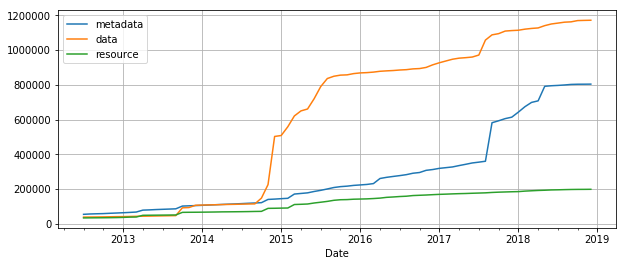

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
data_frame = pd.DataFrame(object_count, columns=columns)
data_frame.set_index('date', inplace=True)

plot = data_frame.plot(figsize=(10,4))
plot.set_xlabel("Date")
plot.grid(True)